In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from survae import SurVAE, DEVICE
from survae.data import MNIST_784
from survae.layer import *
from survae.calibrate import *

import json

In [2]:
SAVE_PATH = "./saves/sv_maxpool overnight 4"

In [3]:
mnist_dataset = MNIST_784()

In [4]:
sv_maxpool = SurVAE(
    [DequantizationLayer()] +
    [
        [BijectiveLayer(784, [200, 200]), OrthonormalLayer(784)] # 784 = 28^2
        for _ in range(6)
    ] +
    [MaxPoolingLayer(784, 2, learn_distribution_parameter=True)] + 
    [
        [BijectiveLayer(196, [200, 200]), OrthonormalLayer(196)] # 196 = 14^2
        for _ in range(6)
    ] +
    [MaxPoolingLayer(196, 2, learn_distribution_parameter=True)] +
    [
        [BijectiveLayer(49, [200, 200]), OrthonormalLayer(49)] # 49 = 7^2
        for _ in range(6)
    ] +
    [MaxPoolingLayerWithHop(49, 3, 2, learn_distribution_parameter=True)] +
    [
        [BijectiveLayer(9, [200, 200]), OrthonormalLayer(9)] # 9 = 3^2
        for _ in range(6)
    ],
    name = "SV_MAXPOOL",
    condition_size = 10,
)

In [5]:
train_log = sv_maxpool.train(
    dataset    = mnist_dataset,
    batch_size = 1000,
    test_size  = 100,
    epochs     = 80_000,
    lr         = 5e-3,
    log_period = 800,
    show_tqdm  = True,
    lr_decay_params = {'gamma': 0.95, 'step_size': 500},
    save_path = SAVE_PATH,
)

100%|██████████| 80000/80000 [8:32:49<00:00,  2.60it/s]  


In [6]:
# orthonormal test (sanity check)
for layer in sv_maxpool.layers:
    if not isinstance(layer, OrthonormalLayer): continue

    _o = layer.o
    assert torch.allclose(_o @ _o.T, torch.eye(_o.shape[0]))

### Plot loss

In [7]:
times = list(train_log.keys())
loss_train = [m.training_loss for m in train_log.values()]
loss_test = [m.testing_loss for m in train_log.values()]
# print(loss_train)

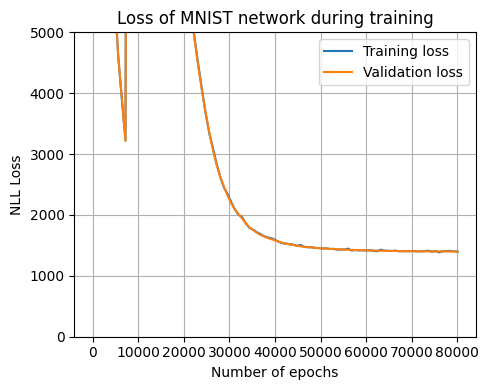

In [12]:
plt.figure(figsize=(5, 4))

plt.plot(times, loss_train, label='Training loss')
plt.plot(times, loss_test, label='Validation loss')

plt.title('Loss of MNIST network during training')
plt.xlabel('Number of epochs')
plt.ylabel('NLL Loss')

plt.grid()
# plt.semilogy()
plt.ylim(0, 5000)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# load model
# sv_maxpool.load_state_dict(torch.load("./saves/sv_maxpool test/epoch_199.pt"))

In [13]:
# check that sigma parameters are actually being learned
for _layer in sv_maxpool.layers:
    if isinstance(_layer, (MaxPoolingLayer, MaxPoolingLayerWithHop)):
        print(f"{(_s := _layer.sigma).item():.4f}")
        # print(f"   {_s.grad.item():.4f}")

5.8761
0.3666
0.0233


In [23]:
# save loss values
with open(SAVE_PATH + "/output/loss_test.txt", "w") as f:
    json.dump(loss_test, f, indent=0)

with open(SAVE_PATH + "/output/loss_train.txt", "w") as f:
    json.dump(loss_train, f, indent=0)

In [ ]:
# load loss values
with open(SAVE_PATH + "/output/loss_test.txt", "r") as f:
    _loss_test = json.load(f)

with open( SAVE_PATH + "/output/loss_train.txt", "r") as f:
    _loss_train = json.load(f)

## Calibration

In [14]:
X, y = mnist_dataset.sample(10_000, labels=True)
y = mnist_dataset.label_to_one_hot(y, 10)

with torch.no_grad():
    Z = sv_maxpool(X, y).cpu()

In [15]:
# calculate standard deviation
sigma = Z.std().item()
print(f"Standard deviation of code distribution is measured to be {sigma:.4f}")

Standard deviation of code distribution is measured to be 0.4582


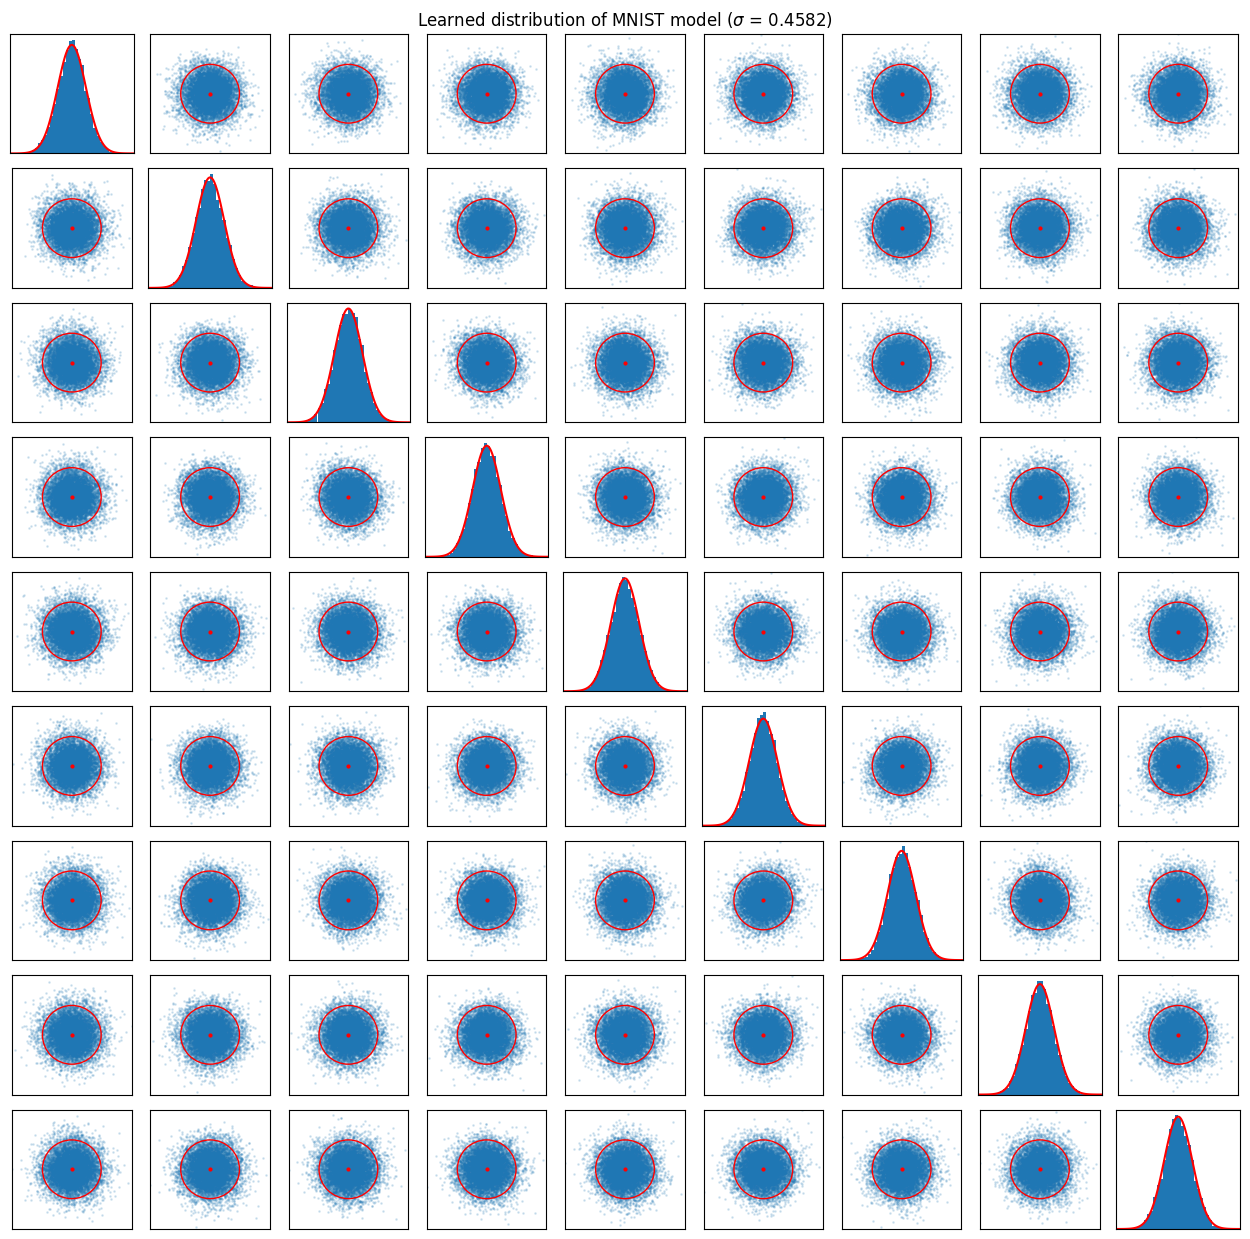

In [18]:
plot_learned_distribution(Z, f"Learned distribution of MNIST model ($\sigma$ = {sigma:.4f})", plotsize=1.4, axis_scale=2, sigma=sigma)

## Sampling

In [19]:
ncols = 10
nrows = 4
plotsize = 1.5

In [20]:
# sample 1's
# _y = torch.tensor([1]).expand(ncols * nrows)

# sample every kind of number several times
_y = torch.arange(10).repeat(nrows)
print(_y)

y = mnist_dataset.label_to_one_hot(_y, 10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


In [21]:
# manually specify the standard deviation for the samples
Z_hat = torch.normal(0, sigma, size=(ncols * nrows, 9), device=DEVICE)
with torch.no_grad():
    X_hat = sv_maxpool.backward(Z_hat, y).view(nrows, ncols, 28, 28).cpu()

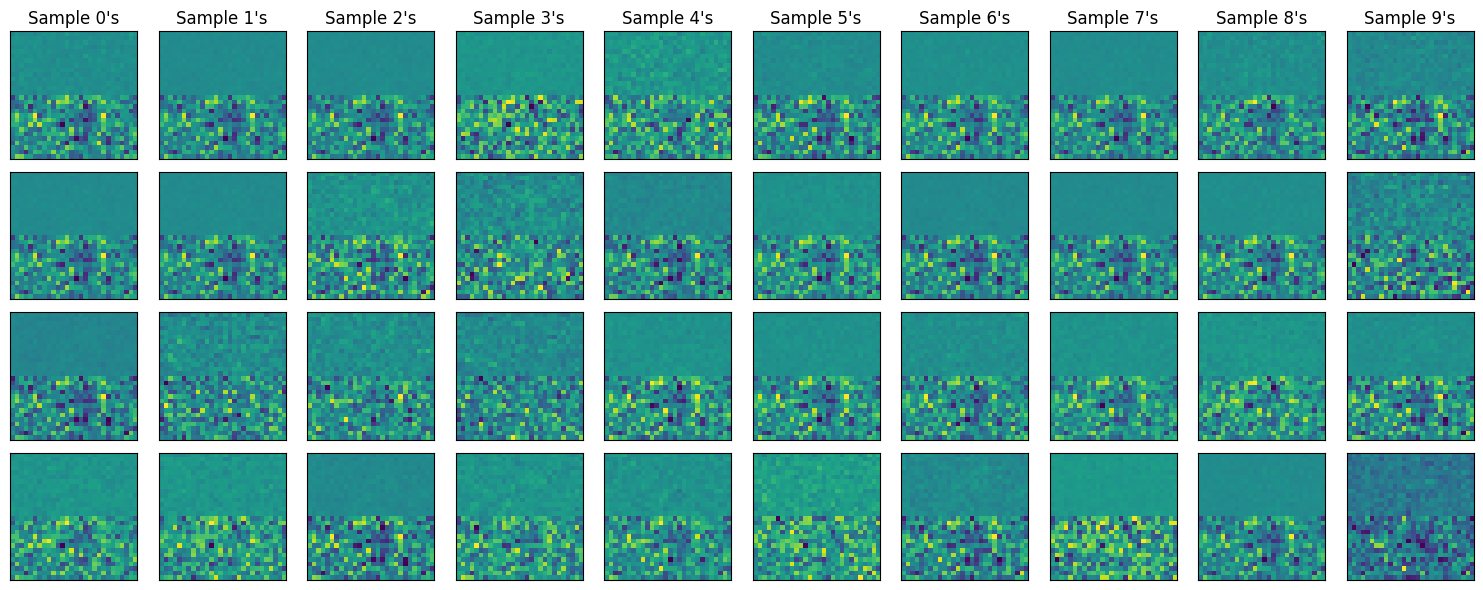

In [22]:
fig, ax = plt.subplots(nrows, ncols, figsize=(plotsize * ncols, plotsize * nrows))

for j in range(ncols):
    ax[0, j].set_title(f"Sample {j}'s")
    for i in range(nrows):
        _ax = ax[i, j]
        _ax.imshow(X_hat[i, j])
        _ax.set_xticks([])
        _ax.set_yticks([])

plt.tight_layout()
plt.show()

## Trace sample through model

In [ ]:
Z = Z_hat
trace_Z = [Z]
layer_names = ["Noise"]

with torch.no_grad():
    for layer in reversed(sv_maxpool.layers):
        Z = layer.backward(Z, y)
        trace_Z.append(Z)
        layer_names.append(type(layer))

In [ ]:
fig, ax = plt.subplots(len(trace_Z), 1, figsize=(2, 2 * len(trace_Z)))

for i, _Z in enumerate(trace_Z):
    _ax = ax[i]
    width = int(np.sqrt(_Z.shape[-1]))
    _ax.imshow(_Z[0].reshape(width, width).cpu().numpy())

    _ax.set_title(layer_names[i])
    _ax.set_xticks([])
    _ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
orthos = []

for layer in reversed(sv_maxpool.layers):
    if isinstance(layer, OrthonormalLayer):
        orthos.append(layer.o)

In [ ]:
plt.imshow(gradient[0].cpu().numpy())

In [ ]:
# shuffled = trace_Z[-3].flatten(start_dim=1) @ orthos[-1]
shuffled = gradient.flatten(start_dim=1) @ orthos[-1]

In [ ]:
plt.imshow(trace_Z[-3][0].reshape(28, 28).cpu().numpy())
plt.show()
plt.imshow(shuffled[0].reshape(28, 28).cpu().numpy())
plt.show()
plt.imshow(trace_Z[-4][0].reshape(28, 28).cpu().numpy())
plt.show()

## Check that it outputs data in the correct interval

In [ ]:
X_hat[..., 14:, :].shape

In [24]:
X_hist, bins = np.histogram(X_hat.flatten(), bins=30, density=True)

In [25]:
bins_centered = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

x_05, x_95 = X_hat.quantile(torch.tensor([0.005, 0.995]).cpu())

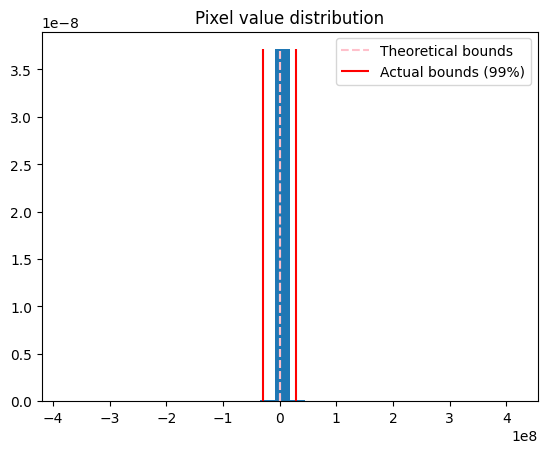

In [26]:
plt.bar(bins_centered, X_hist, bin_width)
plt.vlines([0, 255], 0, X_hist.max(), color='pink', linestyles='--', label='Theoretical bounds')
plt.vlines([x_05, x_95], 0, X_hist.max(), color='red', label='Actual bounds (99%)')

plt.legend()
plt.title("Pixel value distribution")
plt.show()

# MaxPoolingLayer development (kept for potential use in report)

In [ ]:
stride = 3
k = torch.distributions.categorical.Categorical(torch.tensor([1/stride**2] * stride**2))

In [ ]:
X = torch.rand((5, 2, 2))

In [ ]:
X

In [ ]:
i_x = k.sample((5, 2, 2))
i_x

In [ ]:
j = i_x.repeat_interleave(3, dim=2).repeat_interleave(3, dim=1)
j

In [ ]:
m = torch.arange(stride**2).reshape(stride, stride).repeat(2, 2)
m

In [ ]:
mask = (m == j)

In [ ]:
mask

In [ ]:
distr = torch.distributions.half_normal.HalfNormal(1)

In [ ]:
noise = distr.sample((5, 6, 6))

In [ ]:
noise[mask] = 0

In [ ]:
Y

In [ ]:
i_x

In [ ]:
Y.repeat_interleave(stride, dim=1).repeat_interleave(stride, dim=2)# - noise

In [ ]:
noise